In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob 

from astropy.table import Table

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [6]:
# sunspot number data:
# https://wwwbis.sidc.be/silso/datafiles
# found in Adam Kowalski's 2022 colloqium @ UW

df = pd.read_csv('SN_d_tot_V2.0.csv', delimiter=';', 
                 names=('yr', 'mo','day','fracdate','Num','Std','Nobs','DefInd'))
df

,yr,mo,day,fracdate,Num,Std,Nobs,DefInd
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
74595,2022,3,27,2022.234,94,14.8,30,0
74596,2022,3,28,2022.237,136,19.8,50,0
74597,2022,3,29,2022.240,144,32.6,24,0
74598,2022,3,30,2022.242,113,23.5,23,0


(1975.0, 2025.0)

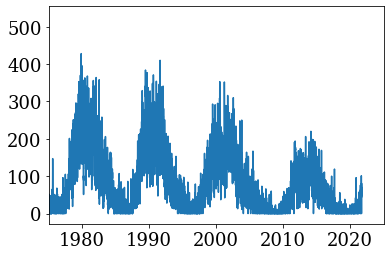

In [9]:
ok = df['DefInd'] > 0
plt.plot(df['fracdate'][ok], df['Num'][ok])
plt.xlim(1975,2025)

In [24]:
np.std(FI)

77.38313536731242

In [13]:
import celerite
from celerite import terms
from scipy.optimize import minimize
# A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 44
# S0 = np.var(FI) / (w0 * Q)
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter('log_Q')

# A periodic component

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp,):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [146]:
DD = df['fracdate'][ok].values
FI = df['Num'][ok].values

bounds = dict(log_S0=(-0, 15), log_Q=(-15, 15), log_omega0=(-15, 5))

EPAD = 120.

Q = 1.0 
w0 = 2*np.pi/11.
S0 = np.var(FI) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
kernel = kernel + terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                                log_omega0=np.log(2*np.pi/150),
                        bounds=bounds)

# gp = celerite.GP(kernel, mean=np.mean(FI), fit_mean=True)
gp = celerite.GP(kernel, mean=0., fit_mean=False)

gp.compute(DD, yerr=np.std(FI)+EPAD)

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method='L-BFGS-B', bounds=bounds, args=(FI, gp))
gp.set_parameter_vector(soln.x)

# print(2*np.pi / np.exp(gp.get_parameter_dict()['kernel:log_omega0']))
for k in gp.get_parameter_dict().values():
    print(2*np.pi/np.exp(k))

0.004959298801199543
1.561332616209638
10.10898013155621
1.3105233218955237e-05
14.949340898645573
284.9574464176844


In [147]:
x = np.linspace(1818, 2055, 500)
mu, var = gp.predict(FI, x, return_var=True)

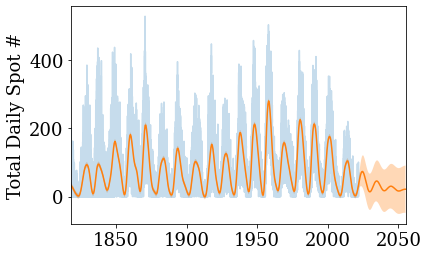

In [150]:
# plt.figure(figsize=(9,7))
plt.plot(DD, FI, alpha=0.25)
plt.plot(x, mu)
plt.fill_between(x, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")
plt.xlim(x.min(), x.max())
plt.ylabel('Total Daily Spot #')
plt.savefig('solar_spot_gp_big.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

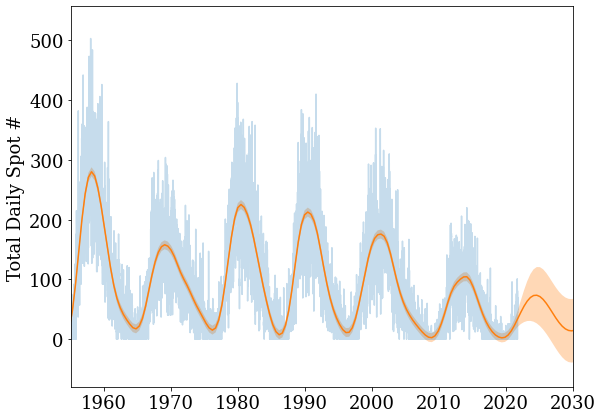

In [151]:
plt.figure(figsize=(9,7))
plt.plot(DD, FI, alpha=0.25)
plt.plot(x, mu)
plt.fill_between(x, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")
plt.xlim(1955,2030)
plt.ylabel('Total Daily Spot #')

plt.savefig('solar_spot_gp.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0, 0.5, 'Total Daily Spot #')

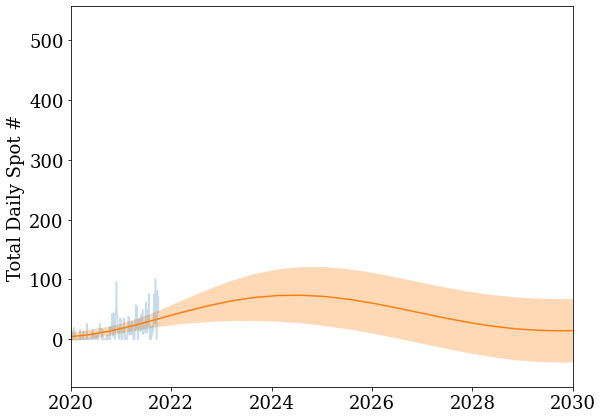

In [152]:
plt.figure(figsize=(9,7))
plt.plot(DD, FI, alpha=0.25)
plt.plot(x, mu)
plt.fill_between(x, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
                 edgecolor="none")
plt.xlim(2020,2030)
plt.ylabel('Total Daily Spot #')

2024.4188376753507


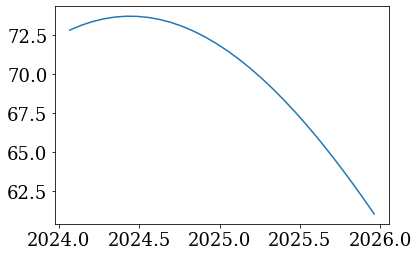

In [120]:
x = np.linspace(2020, 2055, 500)
mu, var = gp.predict(FI, x, return_var=True)

hmm = (x > 2024) & (x < 2026)
plt.plot(x[hmm], mu[hmm])
# plt.fill_between(x, mu+np.sqrt(var), mu-np.sqrt(var), color='C1', alpha=0.3,
#                  edgecolor="none")

print(x[hmm][np.argmax(mu[hmm])])